In [2]:
import pandas as pd
import numpy as np

In [3]:
data = pd.read_csv('okx_BTCUSDT_1min_data.csv')
data = data.rename(columns={'Datetime': 'datetime'})
data.set_index(pd.to_datetime(data['datetime']), inplace=True, drop=True)
data = data.drop(columns=['datetime', 'open_time'])

ret_30min = data[['close']].pct_change(periods=30).shift(-31).dropna()
ret_30min.columns = ['ret_30min']
ret_1d = data[['open']].pct_change(periods=1440).shift(-1441).dropna()
ret_1d.columns = ['ret_1d']

In [4]:
ret_1d.resample('D').first()

,ret_1d
datetime,
2024-01-01,0.064906
2024-01-02,-0.000620
2024-01-03,-0.044613
2024-01-04,0.010051
2024-01-05,0.007117
...,...
2024-10-31,-0.037155
2024-11-01,-0.000588
2024-11-02,-0.014325


In [5]:
ret_1d.resample('D').first().describe()

,ret_1d
count,309.000000
mean,0.001911
std,0.027044
min,-0.116266
25%,-0.011820
50%,0.000119
75%,0.016116
max,0.089472


In [6]:
def calc_ic(ret: pd.DataFrame, factor: pd.DataFrame):
    ret = ret.reindex(factor.index).dropna()
    factor = factor.reindex(ret.index)
    return np.corrcoef(np.array(ret).squeeze(), np.array(factor).squeeze())

In [7]:
data

,open,high,low,close,volume
datetime,,,,,
2024-01-01 00:00:00,42398.1,42402.3,42392.0,42401.0,3.391989
2024-01-01 00:01:00,42400.1,42400.1,42339.8,42359.0,8.907504
2024-01-01 00:02:00,42359.1,42373.9,42350.6,42360.1,7.656267
2024-01-01 00:03:00,42360.1,42360.1,42320.4,42320.4,7.767605
2024-01-01 00:04:00,42322.0,42325.3,42316.2,42322.8,1.119983
...,...,...,...,...,...
2024-11-05 02:44:00,68903.0,68934.9,68903.0,68919.0,1.545942
2024-11-05 02:45:00,68919.9,68937.9,68900.0,68937.9,2.638381
2024-11-05 02:46:00,68937.9,68974.8,68908.0,68912.5,4.529232


In [8]:
# 全局变量freq代表输入量价数据的频率，如1min级别则freq=1
freq = 1
# 得到因子的频率，如15min计算一次因子则为15
factor_freq = 60*24

def volume_vol_factor(data, win=factor_freq):
    """
    volume的波动率
    """

    df_volume = data[['volume']]
    sigma = df_volume.rolling(window=int(win/freq), step=int(win/freq)).std()
    sigma.columns = ['volume_vol']
    return sigma


def volume_vol_vol_factor(data, win=factor_freq, win2=20):
    """
    长江证券高频因子九-高频成交量波动因子
    volume波动率的波动率
    """

    df_volume = data[['volume']]
    # 每30分钟计算一次过去30分钟成交量的标准差
    sigma_30min = df_volume.rolling(window=int(win/freq), step=int(win/freq)).std()
    # 取过去20个30min的数据进行标准化
    sigma_30min.columns = ['volume_vol_vol']
    return sigma_30min.rolling(win2).std()/sigma_30min.rolling(win2).mean()

def volume_close_corr_factor(data):
    """
    价量相关性
    """
    return pd.DataFrame(data['volume'].rolling(window=2880).corr(data['close']), columns=['volume_close_corr'])

In [9]:
factor1 = volume_vol_vol_factor(data).dropna()
factor2 = volume_vol_factor(data).dropna()
factor3 = volume_close_corr_factor(data).dropna()

In [10]:
factor1

,volume_vol_vol
datetime,
2024-01-21,0.942063
2024-01-22,0.970211
2024-01-23,0.937147
2024-01-24,0.747845
2024-01-25,0.771514
...,...
2024-11-01,0.476920
2024-11-02,0.461697
2024-11-03,0.473040


In [11]:
calc_ic(ret_1d.resample('D').first(), factor3)

array([[1.        , 0.04438646],
       [0.04438646, 1.        ]])

In [12]:
calc_ic(ret_1d.resample('D').first(), factor2)

array([[1.        , 0.05294285],
       [0.05294285, 1.        ]])

In [13]:
calc_ic(ret_1d.resample('D').first(), factor1)

array([[1.        , 0.07180256],
       [0.07180256, 1.        ]])

## Model

In [14]:
data_concat = pd.concat([ret_1d.resample('D').first(), factor1, factor2, factor3], axis=1).dropna()

In [15]:
data_concat

,ret_1d,volume_vol_vol,volume_vol,volume_close_corr
datetime,,,,
2024-01-21,-0.022963,0.942063,4.404387,-0.299459
2024-01-22,-0.015691,0.970211,7.471565,-0.376891
2024-01-23,-0.010661,0.937147,34.102023,-0.246679
2024-01-24,0.007314,0.747845,16.882595,-0.016713
2024-01-25,0.005266,0.771514,17.697740,-0.103060
...,...,...,...,...
2024-10-31,-0.037155,0.474810,7.701821,0.113366
2024-11-01,-0.000588,0.476920,15.087257,-0.158906
2024-11-02,-0.014325,0.461697,12.343161,0.041932


In [16]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
X_train = data_concat.drop(columns=['ret_1d']).loc[:'20240801']
y_train = data_concat[['ret_1d']].loc[:'20240801']

model.fit(X_train, y_train)

LinearRegression()

In [17]:
y_pred_test = model.predict(data_concat.drop(columns=['ret_1d']).loc['20240802':])
y_pred_test = pd.DataFrame(y_pred_test, index=data_concat.loc['20240802':].index, columns=['y_pred'])

In [18]:
y_pred_test

,y_pred
datetime,
2024-08-02,-0.001269
2024-08-03,0.002015
2024-08-04,0.004094
2024-08-05,0.004003
2024-08-06,0.004716
...,...
2024-10-31,0.004343
2024-11-01,0.000073
2024-11-02,0.003908


In [19]:
np.corrcoef(y_pred_test.squeeze(), np.array(data_concat[['ret_1d']].loc['20240802':]).squeeze())

array([[1.        , 0.09269039],
       [0.09269039, 1.        ]])

In [20]:
data.loc['20240802':]

,open,high,low,close,volume
datetime,,,,,
2024-08-02 00:00:00,64530.1,64541.8,64497.0,64498.1,2.174681
2024-08-02 00:01:00,64498.8,64507.9,64478.9,64492.0,0.480235
2024-08-02 00:02:00,64485.4,64485.4,64368.0,64416.8,9.897390
2024-08-02 00:03:00,64419.7,64460.0,64366.7,64433.9,8.059342
2024-08-02 00:04:00,64433.9,64433.9,64371.3,64409.4,1.484048
...,...,...,...,...,...
2024-11-05 02:44:00,68903.0,68934.9,68903.0,68919.0,1.545942
2024-11-05 02:45:00,68919.9,68937.9,68900.0,68937.9,2.638381
2024-11-05 02:46:00,68937.9,68974.8,68908.0,68912.5,4.529232


Starting Portfolio Value: 100000.00
Ending Portfolio Value: 104460.68


ValueError: Axis limits cannot be NaN or Inf

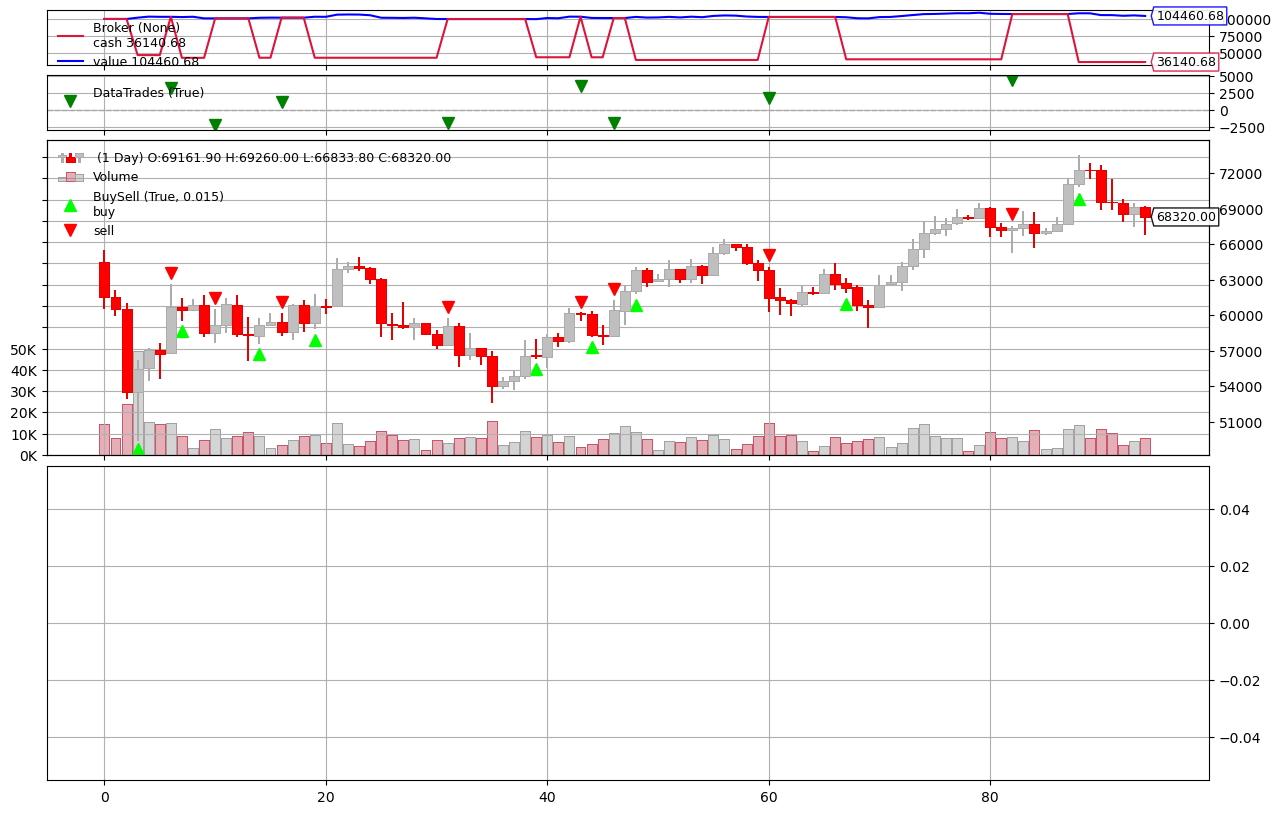

In [41]:
ohlc_test = data['close'].resample('D').ohlc().reindex(y_pred_test.index)
ohlc_test['volume'] = data['volume'].resample('D').sum().reindex(y_pred_test.index)
#ohlc_test['datetime'] = ohlc_test.index

%matplotlib inline
import backtrader as bt
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]  # Set width and height in inches

class PandasSignalData(bt.feeds.PandasData):
    lines = ('y_pred',)  # Define y_pred as a line
    params = (('y_pred', -1),)  # Set y_pred to refer to the y_pred column in the dataframe

# 创建策略类
class SignalStrategy(bt.Strategy):
    params = (
        ('upper_threshold', 0.003),   # 买入阈值
        ('lower_threshold', 0),   # 卖出阈值
    )

    def __init__(self):
        # 假设Signal数据已作为data1传入
        self.signal = self.data1.y_pred  # Signal数据的值假设在close列

    def next(self):
        if not self.position:  # 当前无仓位
            if self.signal[0] > self.params.upper_threshold:
                self.buy()  # 买入
        else:  # 当前有仓位
            if self.signal[0] < self.params.lower_threshold:
                self.sell()  # 卖出

# 假设data和signal是两个DataFrame
# data: 含有价格数据的DataFrame
# signal: 含有Signal数据的DataFrame

# 将DataFrame数据加载到Backtrader
data_feed = bt.feeds.PandasData(dataname=ohlc_test)  # 价格数据
signal_feed = PandasSignalData(dataname=y_pred_test)  # Signal数据

# 设置Cerebro
cerebro = bt.Cerebro()
cerebro.addstrategy(SignalStrategy)

# 添加数据
cerebro.adddata(data_feed)       # 价格数据
cerebro.adddata(signal_feed)     # Signal数据作为data1

# 设置初始资金和佣金
cerebro.broker.setcash(100000)    # 初始资金
cerebro.broker.setcommission(commission=0.001)  # 假设千分之一佣金

# 运行回测
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
cerebro.run()
print('Ending Portfolio Value: %.2f' % cerebro.broker.getvalue())

# 绘制结果
cerebro.plot(style='candlestick',iplot=False)

In [40]:
ohlc_test

,open,high,low,close,volume
datetime,,,,,
2024-08-02,64498.1,65511.0,60551.9,61558.8,14536.684706
2024-08-03,61585.0,62184.1,59907.0,60564.0,8034.075049
2024-08-04,60557.8,61074.5,52949.5,53523.9,23743.599006
2024-08-05,53525.4,56216.0,49414.4,55494.1,48796.103763
2024-08-06,55555.9,57228.0,54486.9,57048.0,15558.081665
...,...,...,...,...,...
2024-10-31,72260.1,72680.0,68884.2,69600.9,12151.178175
2024-11-01,69575.3,71544.0,68872.6,69569.1,10463.856255
2024-11-02,69534.5,69847.9,67897.5,68589.9,4565.067354
